# **Underperfoaming Student Prediction: A Data-Driven Approach using C-CatBoost and Ensemble**

Underperforming Student Prediction & Analysis is a machine learning project that predicts at‑risk students using academic and engagement features. It includes data cleaning, exploratory analysis, model training/evaluation, and actionable insights to support data‑driven academic interventions. [Base Research Paper Link](https://www.sciencedirect.com/science/article/abs/pii/S0031320324010161?via%3Dihub)

Step 1: Load all three dataset files:

*   (student-mat.csv)
*   (student-por.csv)
*   (exams.csv)

In [1]:
import pandas as pd
import numpy as np

mat = pd.read_csv('student-mat.csv', sep=';')
por = pd.read_csv('student-por.csv', sep=';')
exams = pd.read_csv('exams.csv')

print("Datasets loaded:", mat.shape, por.shape, exams.shape)

Datasets loaded: (395, 33) (649, 33) (1000, 8)


Step 2: Leakage control (drop G1, G2 from UCI Machine Repository's Obtained 2 dataset files):
*   (student-mat.csv)
*   (student-por.csv)

In [2]:
mat_noleak = mat.drop(['G1', 'G2'], axis=1)
por_noleak = por.drop(['G1', 'G2'], axis=1)

print("After leakage removal:", mat_noleak.shape, por_noleak.shape)

After leakage removal: (395, 31) (649, 31)


Step 3: Binning Target Variables from all three datasets into 3 Categories;

*   Low
*   Medium
*   High

In [3]:
def bin_grades(g3_series, dataset_name):
    if dataset_name == 'mat' or dataset_name == 'por':
        bins = [0, 9, 15, 21]
        labels = ['Low', 'Medium', 'High']
    else:
        bins = [0, 60, 80, 101]
        labels = ['Low', 'Medium', 'High']
    return pd.cut(g3_series, bins=bins, labels=labels, right=False)

mat_noleak['target'] = bin_grades(mat_noleak['G3'], 'mat')
por_noleak['target'] = bin_grades(por_noleak['G3'], 'por')
exams['target'] = bin_grades(exams['math score'], 'exams')

print("Class distributions:")
print("Mat:", mat_noleak['target'].value_counts())
print("Por:", por_noleak['target'].value_counts())
print("Exams:", exams['target'].value_counts())

Class distributions:
Mat: target
Medium    220
Low       102
High       73
Name: count, dtype: int64
Por: target
Medium    453
High      131
Low        65
Name: count, dtype: int64
Exams: target
Medium    464
Low       328
High      208
Name: count, dtype: int64


Step 4: Prepare features and targets for all 3 Dataset Files Obtained.

In [4]:
X_mat = mat_noleak.drop(['G3', 'target'], axis=1)
y_mat = mat_noleak['target']

X_por = por_noleak.drop(['G3', 'target'], axis=1)
y_por = por_noleak['target']

X_exams = exams.drop(['math score', 'reading score', 'writing score', 'target'], axis=1)
y_exams = exams['target']

datasets = {
    'Mathematics': (X_mat, y_mat),
    'Portuguese': (X_por, y_por),
    'Exams': (X_exams, y_exams)
}

Step 5: Data Preprocessing Pipeline.

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def get_preprocessor(X):
    cat_cols = X.select_dtypes(include=['object']).columns
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ])
    return preprocessor

Step 6: Importing Essencial Libraries for ML Modelling.

In [6]:
!pip install catboost
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Fixed seed for reproducibility
SEED = 42
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


Step 7: Train-test split, ML model training and Ensembling.

In [7]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

results = {}
feature_importances = {}

for name, (X, y) in datasets.items():
    print(f"\n=== {name} Dataset ===")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    # Encode target labels to 0,1,2 for XGBoost
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    preprocessor = get_preprocessor(X_train)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Models
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
    ada = AdaBoostClassifier(n_estimators=100, random_state=SEED)
    xgb = XGBClassifier(n_estimators=100, random_state=SEED, eval_metric='mlogloss')
    lgb = LGBMClassifier(n_estimators=100, random_state=SEED)
    cat = CatBoostClassifier(n_estimators=100, random_state=SEED, verbose=0)

    # C-CatBoost (as per paper: CatBoost with custom params)
    c_cat = CatBoostClassifier(
        n_estimators=100,
        random_state=SEED,
        verbose=0,
        cat_features=None,  # will handle via preprocessing
        learning_rate=0.05,
        depth=6
    )

    # Voting Ensemble
    voting = VotingClassifier(
        estimators=[
            ('rf', rf),
            ('xgb', xgb),
            ('lgb', lgb),
            ('cat', cat)
        ],
        voting='soft'
    )

    models = {
        'Random Forest': rf,
        'AdaBoost': ada,
        'XGBoost': xgb,
        'LightGBM': lgb,
        'CatBoost': cat,
        'C-CatBoost': c_cat,
        'Voting Ensemble': voting
    }

    best_f1 = 0
    best_model_name = ""
    best_preds = None

    for model_name, model in models.items():
        # Use encoded targets for XGBoost, original for others
        if model_name == 'XGBoost':
            model.fit(X_train_processed, y_train_encoded)
            y_pred_encoded = model.predict(X_test_processed)
            y_pred = le.inverse_transform(y_pred_encoded)
        else:
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)

        weighted_f1 = f1_score(y_test, y_pred, average='weighted')
        weighted_precision = precision_score(y_test, y_pred, average='weighted')
        weighted_recall = recall_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        if weighted_f1 > best_f1:
            best_f1 = weighted_f1
            best_model_name = model_name
            best_preds = y_pred

        print(f"{model_name:20} | Acc: {acc:.4f} | Prec: {weighted_precision:.4f} | Rec: {weighted_recall:.4f} | F1: {weighted_f1:.4f}")

    # Permutation importance for best model
    best_model = models[best_model_name]
    # Use encoded targets for permutation importance
    if best_model_name == 'XGBoost':
        y_test_for_perm = y_test_encoded
    else:
        y_test_for_perm = y_test

    perm_importance = permutation_importance(
        best_model, X_test_processed, y_test_for_perm,
        n_repeats=10, random_state=SEED, n_jobs=-1
    )

    feature_names = []
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = preprocessor.get_feature_names_out()
    else:
        feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

    feature_importances[name] = {
        'importances': perm_importance.importances_mean,
        'feature_names': feature_names
    }

    results[name] = {
        'best_model': best_model_name,
        'accuracy': accuracy_score(y_test, best_preds),
        'precision': precision_score(y_test, best_preds, average='weighted'),
        'recall': recall_score(y_test, best_preds, average='weighted'),
        'f1': best_f1
    }

    print(f"\nBest model for {name}: {best_model_name}")
    print(classification_report(y_test, best_preds, target_names=['Low', 'Medium', 'High']))


=== Mathematics Dataset ===
Random Forest        | Acc: 0.6456 | Prec: 0.6420 | Rec: 0.6456 | F1: 0.6039
AdaBoost             | Acc: 0.6962 | Prec: 0.6917 | Rec: 0.6962 | F1: 0.6842
XGBoost              | Acc: 0.5823 | Prec: 0.5720 | Rec: 0.5823 | F1: 0.5733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 51
[LightGBM] [Info] Start training from score -1.695299
[LightGBM] [Info] Start training from score -1.349023
[LightGBM] [Info] Start training from score -0.585258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

Step 8: Display results table after ML Modelling.

In [8]:
print("\n" + "="*70)
print("SUMMARY OF BEST MODELS PER DATASET")
print("="*70)

for dataset, metrics in results.items():
    print(f"\n{dataset}:")
    print(f"  Best Model: {metrics['best_model']}")
    print(f"  Accuracy:   {metrics['accuracy']:.4f}")
    print(f"  Precision:  {metrics['precision']:.4f}")
    print(f"  Recall:     {metrics['recall']:.4f}")
    print(f"  F1-score:   {metrics['f1']:.4f}")


SUMMARY OF BEST MODELS PER DATASET

Mathematics:
  Best Model: AdaBoost
  Accuracy:   0.6962
  Precision:  0.6917
  Recall:     0.6962
  F1-score:   0.6842

Portuguese:
  Best Model: CatBoost
  Accuracy:   0.7077
  Precision:  0.6741
  Recall:     0.7077
  F1-score:   0.6616

Exams:
  Best Model: XGBoost
  Accuracy:   0.4850
  Precision:  0.4843
  Recall:     0.4850
  F1-score:   0.4826


Step 9: Feature importance visualization.

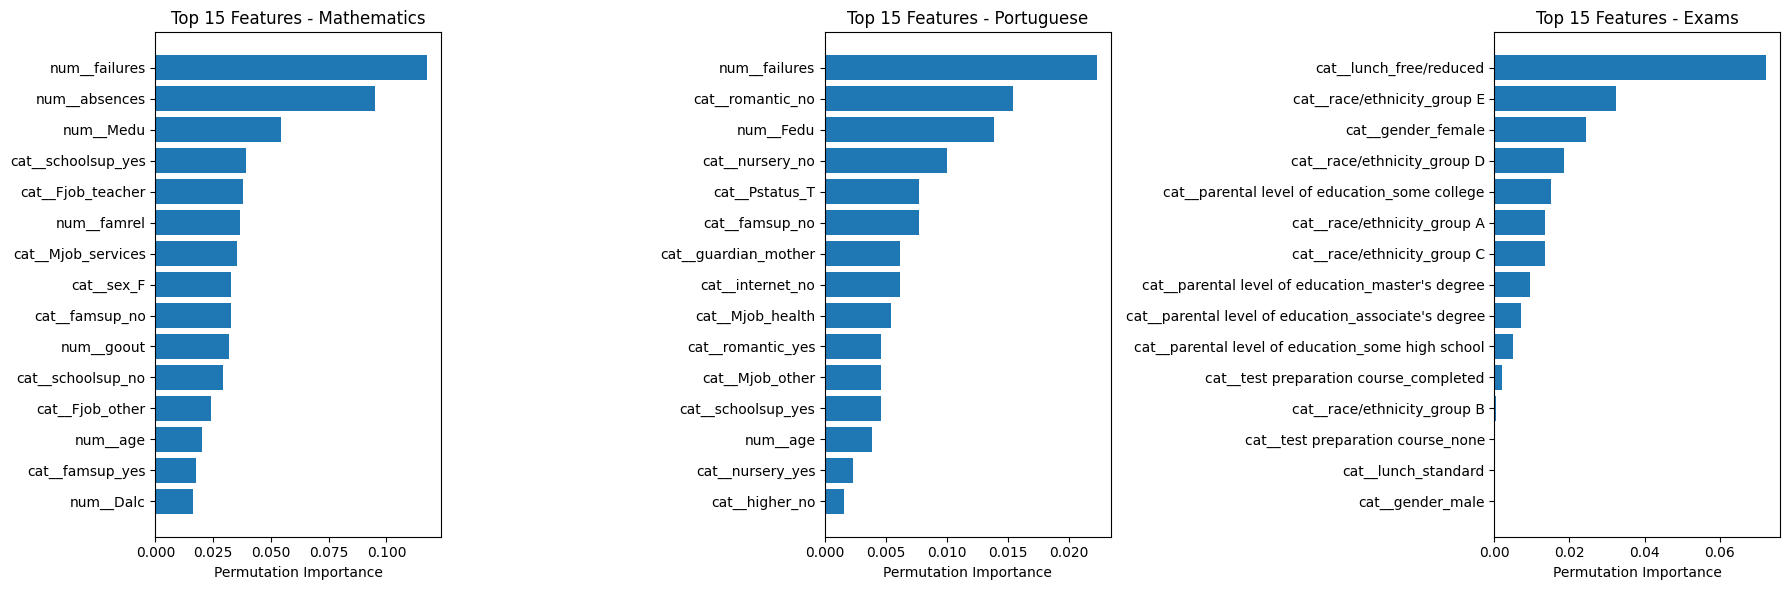

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, (dataset, imp_data) in enumerate(feature_importances.items()):
    importances = imp_data['importances']
    features = imp_data['feature_names']

    # Sort by importance
    sorted_idx = np.argsort(importances)[-15:]  # top 15
    axes[idx].barh(range(len(sorted_idx)), importances[sorted_idx])
    axes[idx].set_yticks(range(len(sorted_idx)))
    axes[idx].set_yticklabels([features[i] for i in sorted_idx])
    axes[idx].set_title(f'Top 15 Features - {dataset}')
    axes[idx].set_xlabel('Permutation Importance')

plt.tight_layout()
plt.show()

Step 10: Final comparison table (as in base research paper) we choosen.

In [10]:
comparison_df = pd.DataFrame([
    {
        'Dataset': 'Mathematics',
        'Best Model': results['Mathematics']['best_model'],
        'Accuracy': f"{results['Mathematics']['accuracy']*100:.2f}%",
        'Precision': f"{results['Mathematics']['precision']*100:.2f}%",
        'F1': f"{results['Mathematics']['f1']*100:.2f}%"
    },
    {
        'Dataset': 'Portuguese',
        'Best Model': results['Portuguese']['best_model'],
        'Accuracy': f"{results['Portuguese']['accuracy']*100:.2f}%",
        'Precision': f"{results['Portuguese']['precision']*100:.2f}%",
        'F1': f"{results['Portuguese']['f1']*100:.2f}%"
    },
    {
        'Dataset': 'Exams',
        'Best Model': results['Exams']['best_model'],
        'Accuracy': f"{results['Exams']['accuracy']*100:.2f}%",
        'Precision': f"{results['Exams']['precision']*100:.2f}%",
        'F1': f"{results['Exams']['f1']*100:.2f}%"
    }
])

print("\n" + "="*70)
print("FINAL COMPARISON TABLE (as in research paper)")
print("="*70)
print(comparison_df.to_string(index=False))


FINAL COMPARISON TABLE (as in research paper)
    Dataset Best Model Accuracy Precision     F1
Mathematics   AdaBoost   69.62%    69.17% 68.42%
 Portuguese   CatBoost   70.77%    67.41% 66.16%
      Exams    XGBoost   48.50%    48.43% 48.26%


Step 11: Correlation Heatmaps for All 3 Datasets.

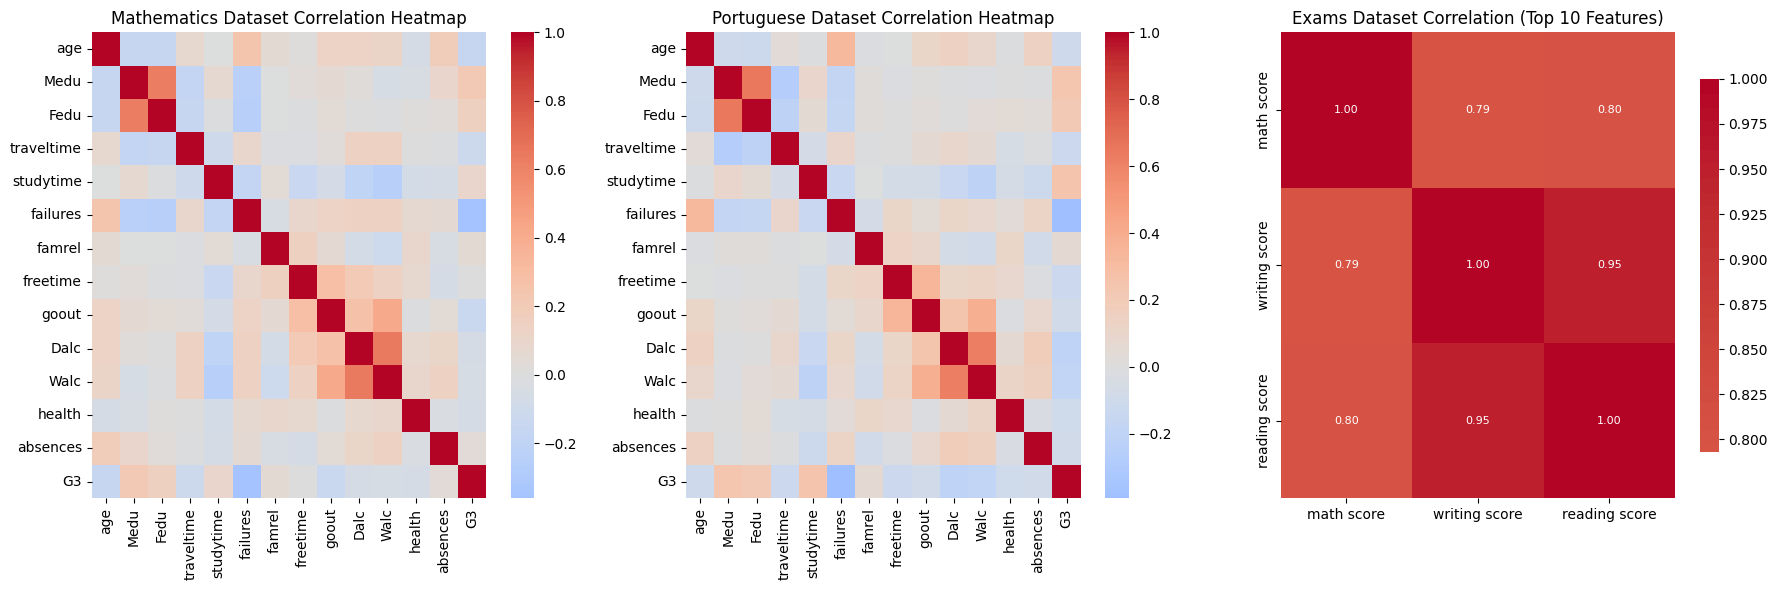

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Mathematics dataset correlation
mat_numeric = mat.select_dtypes(include=[np.number])
if 'G1' in mat_numeric.columns and 'G2' in mat_numeric.columns:
    mat_numeric = mat_numeric.drop(['G1', 'G2'], axis=1)
corr_mat = mat_numeric.corr()
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Mathematics Dataset Correlation Heatmap')

# 2. Portuguese dataset correlation
por_numeric = por.select_dtypes(include=[np.number])
if 'G1' in por_numeric.columns and 'G2' in por_numeric.columns:
    por_numeric = por_numeric.drop(['G1', 'G2'], axis=1)
corr_por = por_numeric.corr()
sns.heatmap(corr_por, annot=False, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Portuguese Dataset Correlation Heatmap')

# 3. Exams dataset correlation
exams_numeric = exams.select_dtypes(include=[np.number])
# Take top 10 most variable columns
exams_numeric = exams_numeric.loc[:, exams_numeric.std().nlargest(10).index]
corr_exams = exams_numeric.corr()
sns.heatmap(corr_exams, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            annot_kws={'size': 8}, ax=axes[2], cbar_kws={'shrink': 0.8})
axes[2].set_title('Exams Dataset Correlation (Top 10 Features)')

plt.tight_layout()
plt.show()

Step 12: Scatter Plots of Important Features, from all three Dataset Files.

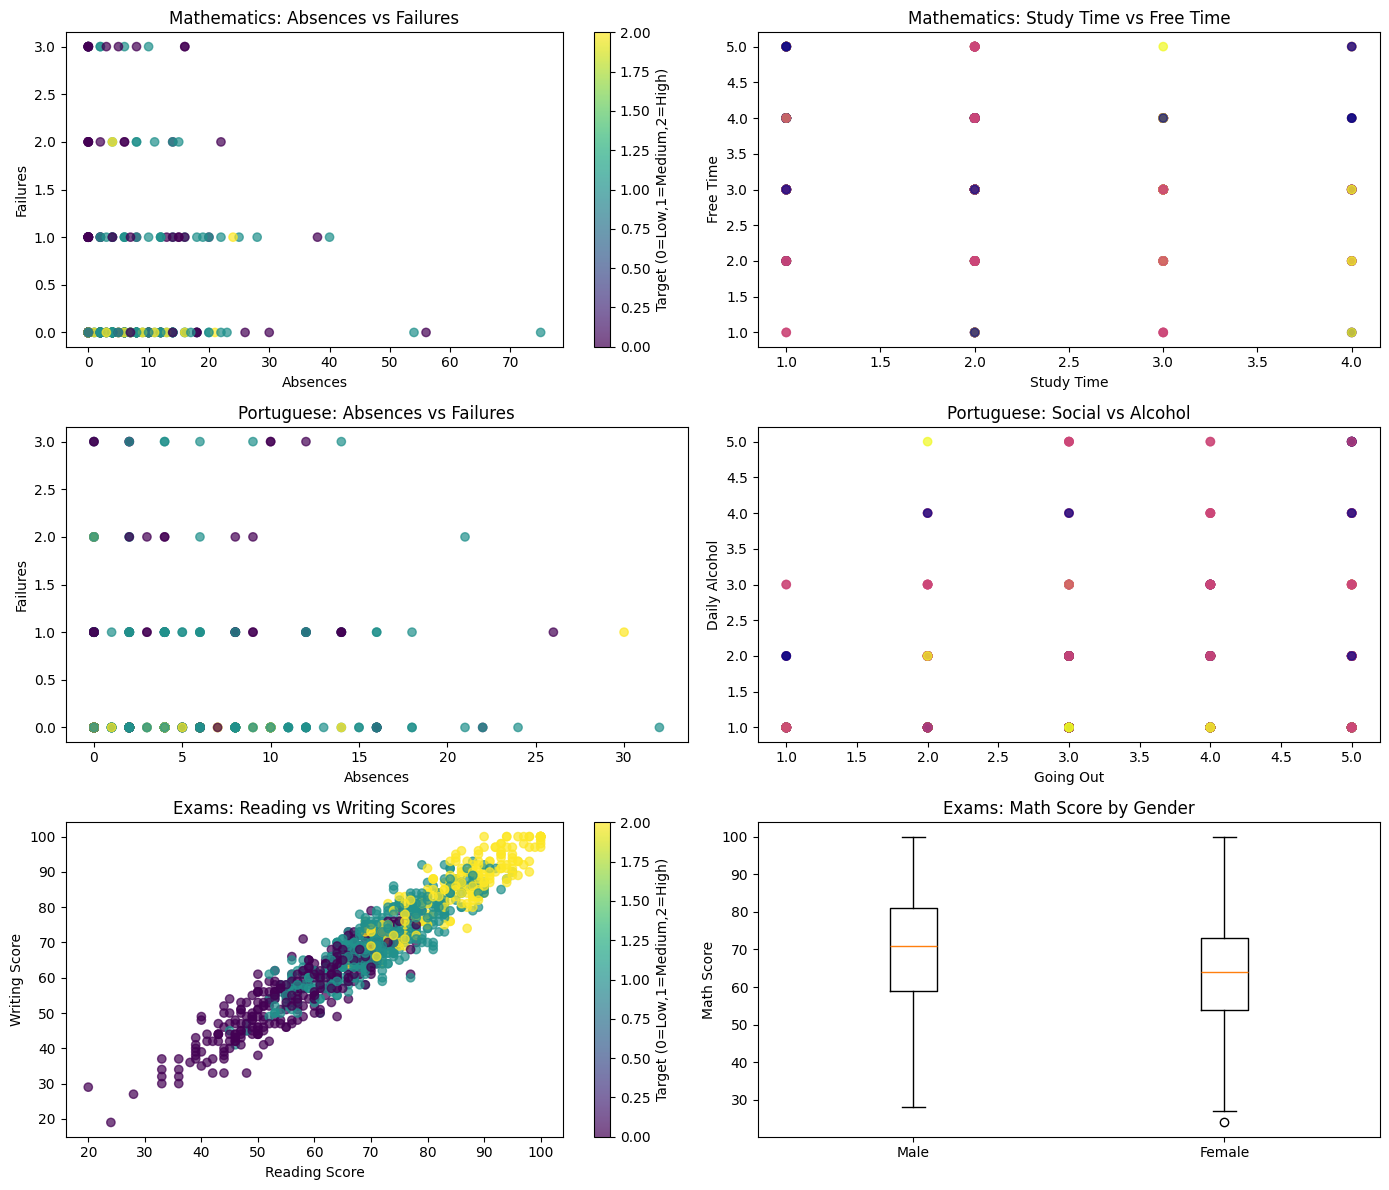

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Mathematics: absences vs failures colored by target
scatter1 = axes[0,0].scatter(mat['absences'], mat['failures'],
                             c=mat_noleak['target'].cat.codes, cmap='viridis', alpha=0.7)
axes[0,0].set_xlabel('Absences')
axes[0,0].set_ylabel('Failures')
axes[0,0].set_title('Mathematics: Absences vs Failures')
plt.colorbar(scatter1, ax=axes[0,0], label='Target (0=Low,1=Medium,2=High)')

# Mathematics: studytime vs freetime
axes[0,1].scatter(mat['studytime'], mat['freetime'],
                  c=mat_noleak['target'].cat.codes, cmap='plasma', alpha=0.7)
axes[0,1].set_xlabel('Study Time')
axes[0,1].set_ylabel('Free Time')
axes[0,1].set_title('Mathematics: Study Time vs Free Time')

# Portuguese: absences vs failures
axes[1,0].scatter(por['absences'], por['failures'],
                  c=por_noleak['target'].cat.codes, cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('Absences')
axes[1,0].set_ylabel('Failures')
axes[1,0].set_title('Portuguese: Absences vs Failures')

# Portuguese: goout vs Dalc (alcohol consumption)
axes[1,1].scatter(por['goout'], por['Dalc'],
                  c=por_noleak['target'].cat.codes, cmap='plasma', alpha=0.7)
axes[1,1].set_xlabel('Going Out')
axes[1,1].set_ylabel('Daily Alcohol')
axes[1,1].set_title('Portuguese: Social vs Alcohol')

# Exams: reading vs writing scores
scatter5 = axes[2,0].scatter(exams['reading score'], exams['writing score'],
                             c=exams['target'].cat.codes, cmap='viridis', alpha=0.7)
axes[2,0].set_xlabel('Reading Score')
axes[2,0].set_ylabel('Writing Score')
axes[2,0].set_title('Exams: Reading vs Writing Scores')
plt.colorbar(scatter5, ax=axes[2,0], label='Target (0=Low,1=Medium,2=High)')

# Exams: math score distribution by gender (boxplot)
gender_map = {'male': 0, 'female': 1}
exams['gender_code'] = exams['gender'].map(gender_map)
box_data = [exams[exams['gender_code']==0]['math score'],
            exams[exams['gender_code']==1]['math score']]
axes[2,1].boxplot(box_data, labels=['Male', 'Female'])
axes[2,1].set_ylabel('Math Score')
axes[2,1].set_title('Exams: Math Score by Gender')

plt.tight_layout()
plt.show()

Step 13: Pair Plots for All 3 Datasets.

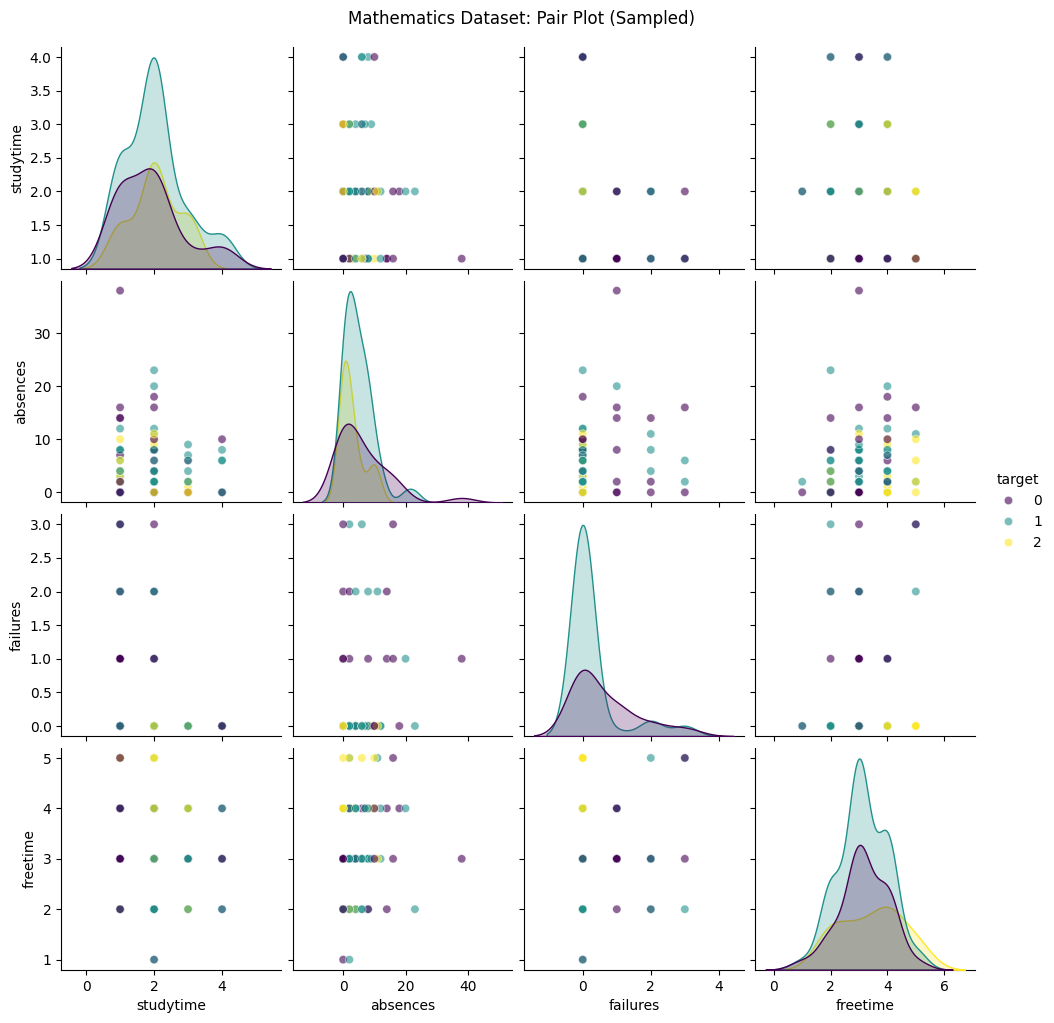

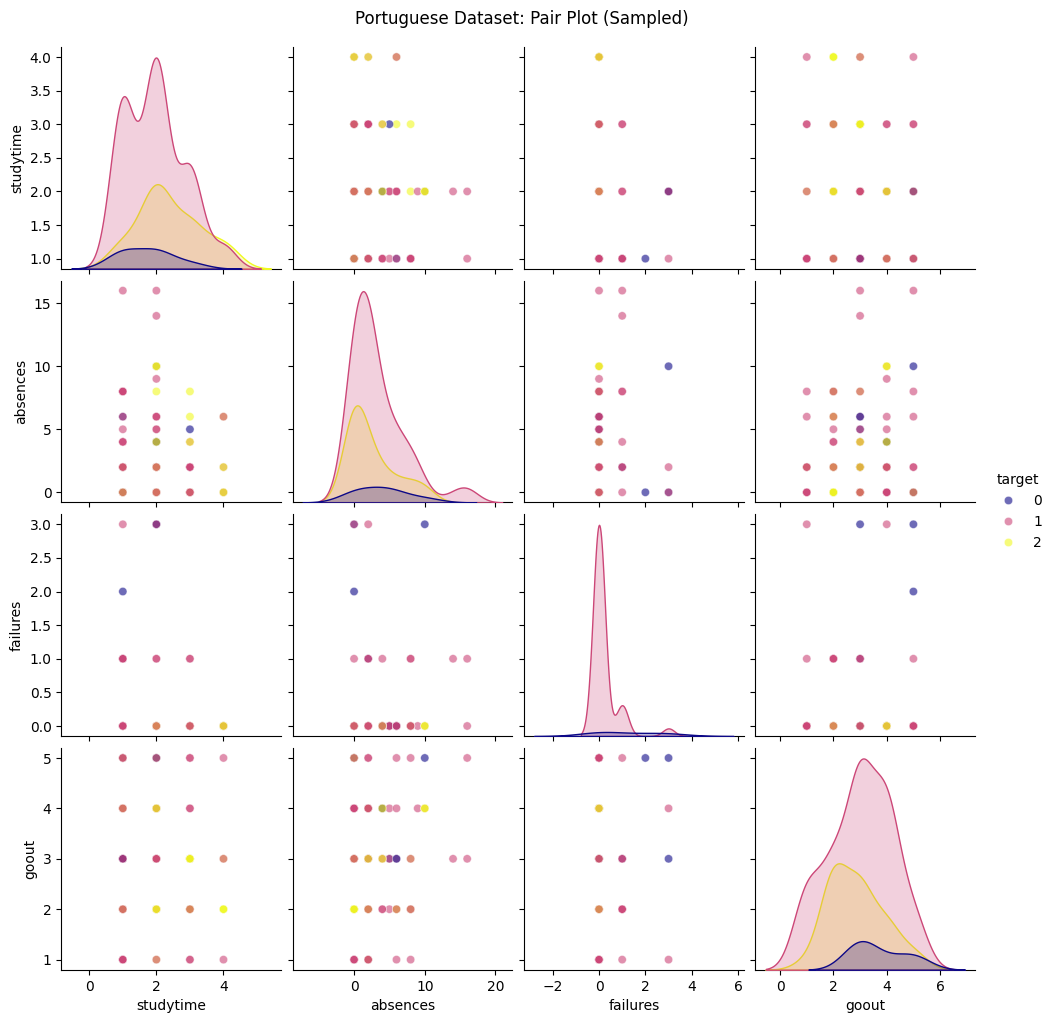

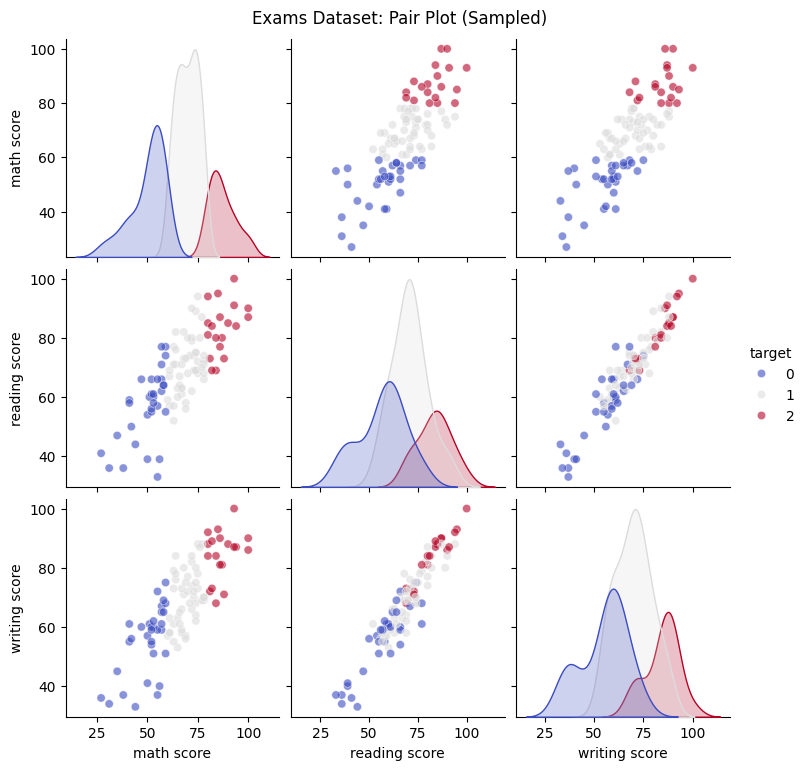

In [13]:
import warnings
warnings.filterwarnings('ignore')

# Sample data for pair plots (to avoid overcrowding)
sample_size = 100
mat_sample = mat_numeric.sample(sample_size, random_state=SEED)
mat_sample['target'] = mat_noleak.loc[mat_sample.index, 'target'].cat.codes
mat_pair_cols = ['studytime', 'absences', 'failures', 'freetime', 'target']

fig1 = sns.pairplot(mat_sample[mat_pair_cols], hue='target',
                    palette='viridis', plot_kws={'alpha': 0.6})
fig1.fig.suptitle('Mathematics Dataset: Pair Plot (Sampled)', y=1.02)
plt.show()

# Portuguese pair plot
por_sample = por_numeric.sample(sample_size, random_state=SEED)
por_sample['target'] = por_noleak.loc[por_sample.index, 'target'].cat.codes
por_pair_cols = ['studytime', 'absences', 'failures', 'goout', 'target']

fig2 = sns.pairplot(por_sample[por_pair_cols], hue='target',
                    palette='plasma', plot_kws={'alpha': 0.6})
fig2.fig.suptitle('Portuguese Dataset: Pair Plot (Sampled)', y=1.02)
plt.show()

# Exams pair plot
exams_sample = exams.sample(sample_size, random_state=SEED)
exams_sample['target'] = exams.loc[exams_sample.index, 'target'].cat.codes
exams_pair_cols = ['math score', 'reading score', 'writing score', 'target']

fig3 = sns.pairplot(exams_sample[exams_pair_cols], hue='target',
                    palette='coolwarm', plot_kws={'alpha': 0.6})
fig3.fig.suptitle('Exams Dataset: Pair Plot (Sampled)', y=1.02)
plt.show()

Step 14: Confusion Matrices for All 3 Datasets.

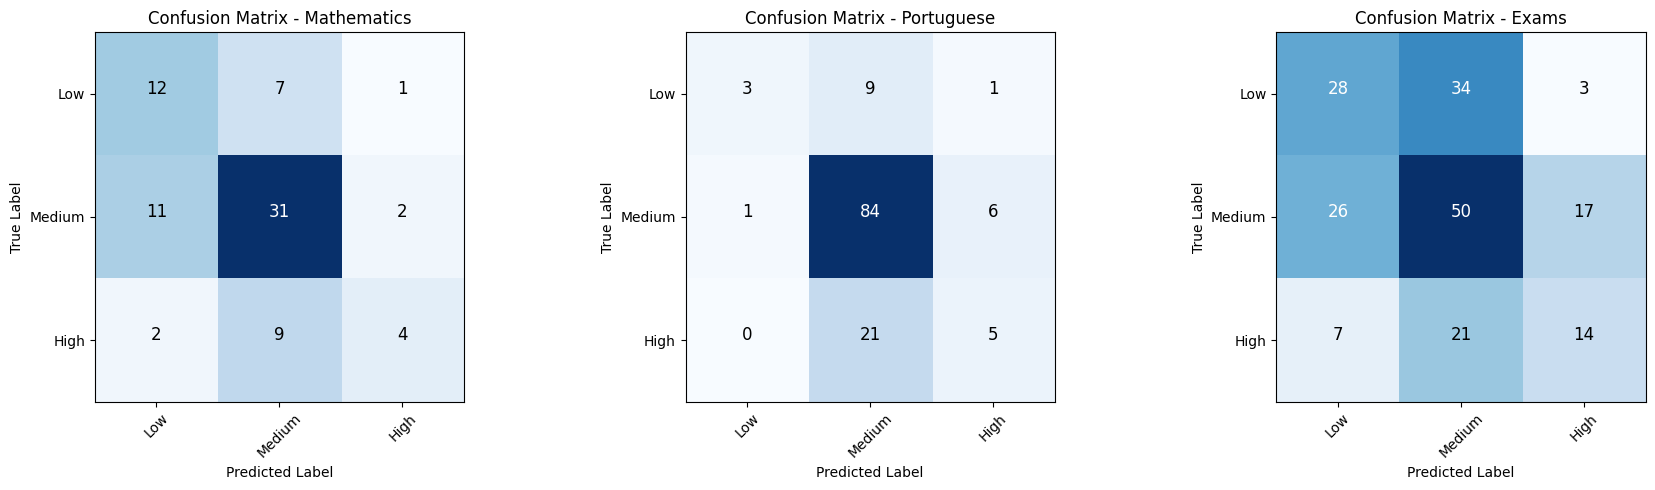

In [14]:
from sklearn.metrics import confusion_matrix
import itertools

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

confusion_data = {}

for idx, (name, (X, y)) in enumerate(datasets.items()):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    preprocessor = get_preprocessor(X_train)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Use best model from results or CatBoost as default
    if name in results:
        best_model_name = results[name]['best_model']
    else:
        best_model_name = 'CatBoost'

    # Train CatBoost for confusion matrix
    model = CatBoostClassifier(n_estimators=100, random_state=SEED, verbose=0)
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)

    cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])

    # Plot confusion matrix
    ax = axes[idx]
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix - {name}')

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12)

    tick_marks = np.arange(len(['Low', 'Medium', 'High']))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['Low', 'Medium', 'High'], rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(['Low', 'Medium', 'High'])
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

Step 15: Class Distribution Bar Graphs.

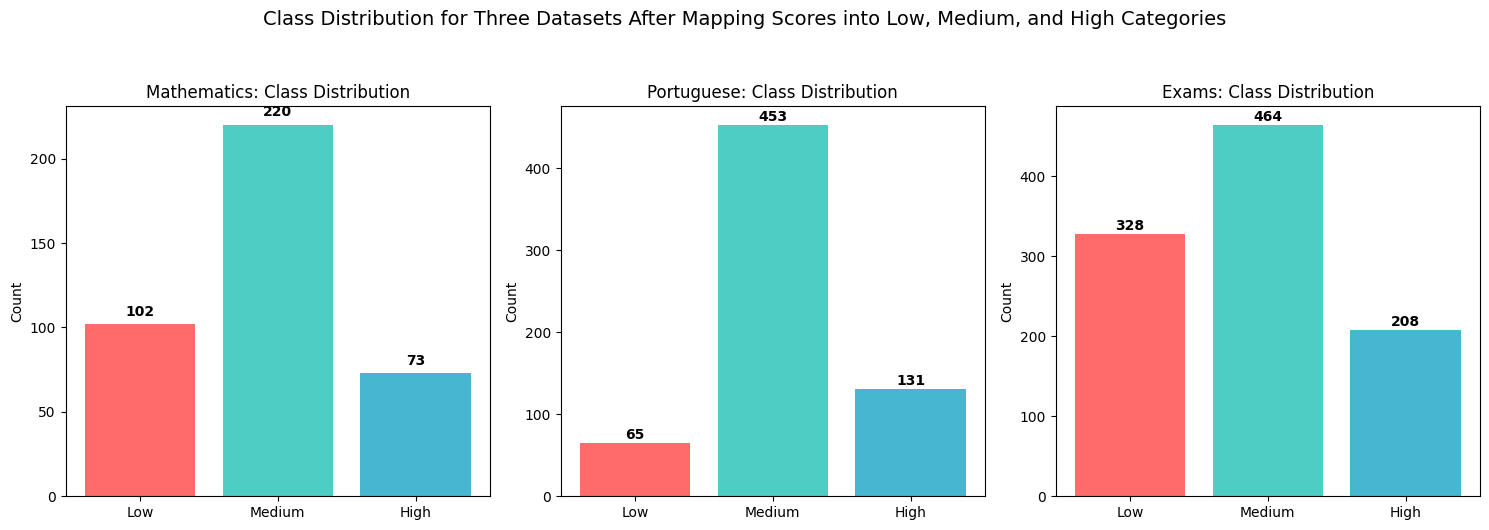

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mathematics class distribution
mat_counts = mat_noleak['target'].value_counts().sort_index()
axes[0].bar(mat_counts.index, mat_counts.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0].set_title('Mathematics: Class Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(mat_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Portuguese class distribution
por_counts = por_noleak['target'].value_counts().sort_index()
axes[1].bar(por_counts.index, por_counts.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[1].set_title('Portuguese: Class Distribution')
axes[1].set_ylabel('Count')
for i, v in enumerate(por_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Exams class distribution
exams_counts = exams['target'].value_counts().sort_index()
axes[2].bar(exams_counts.index, exams_counts.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[2].set_title('Exams: Class Distribution')
axes[2].set_ylabel('Count')
for i, v in enumerate(exams_counts.values):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.suptitle('Class Distribution for Three Datasets After Mapping Scores into Low, Medium, and High Categories',
             fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Step 16: Score Distribution Histograms

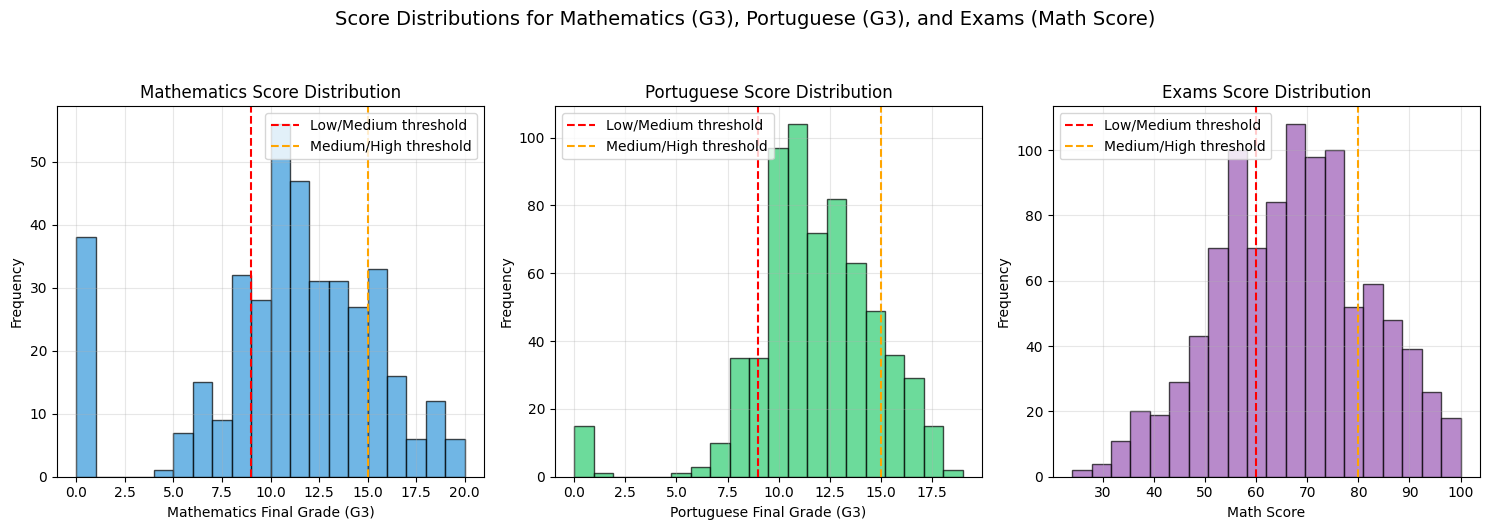

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mathematics G3 distribution
axes[0].hist(mat['G3'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].axvline(x=9, color='red', linestyle='--', label='Low/Medium threshold')
axes[0].axvline(x=15, color='orange', linestyle='--', label='Medium/High threshold')
axes[0].set_xlabel('Mathematics Final Grade (G3)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Mathematics Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Portuguese G3 distribution
axes[1].hist(por['G3'], bins=20, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1].axvline(x=9, color='red', linestyle='--', label='Low/Medium threshold')
axes[1].axvline(x=15, color='orange', linestyle='--', label='Medium/High threshold')
axes[1].set_xlabel('Portuguese Final Grade (G3)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Portuguese Score Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Exams math score distribution
axes[2].hist(exams['math score'], bins=20, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[2].axvline(x=60, color='red', linestyle='--', label='Low/Medium threshold')
axes[2].axvline(x=80, color='orange', linestyle='--', label='Medium/High threshold')
axes[2].set_xlabel('Math Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Exams Score Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Score Distributions for Mathematics (G3), Portuguese (G3), and Exams (Math Score)',
             fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Step 17: Best Test-Set Metrics by Datasets in form of Bar Graphs.

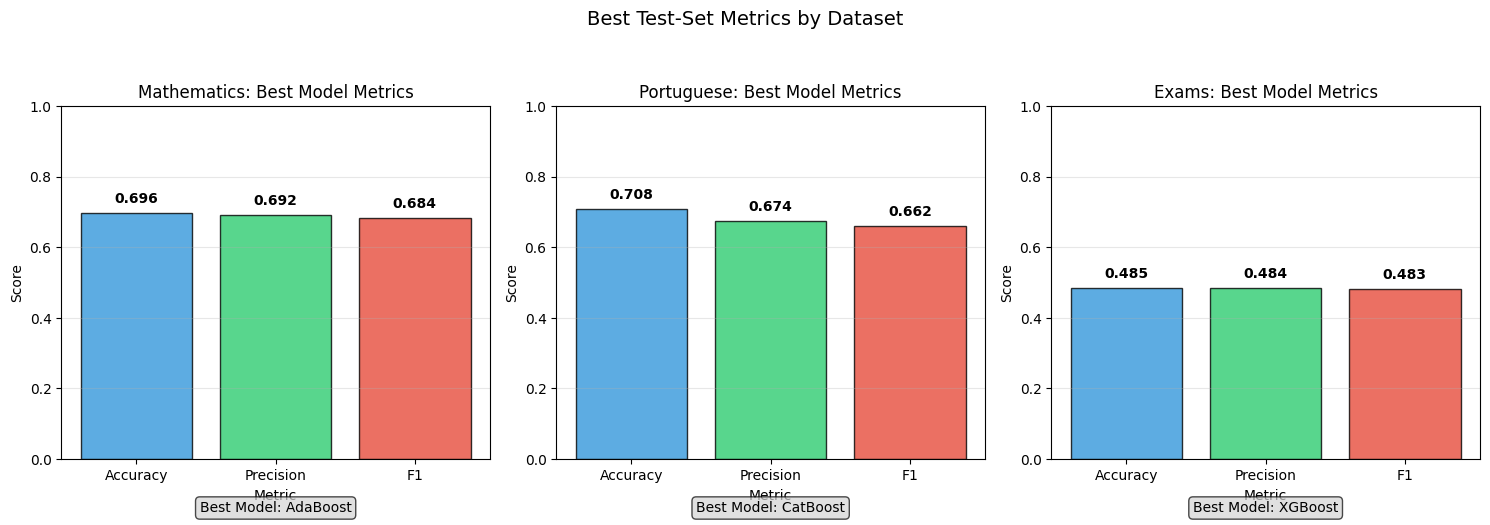

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Accuracy', 'Precision', 'F1']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, dataset in enumerate(['Mathematics', 'Portuguese', 'Exams']):
    if dataset in results:
        acc = results[dataset]['accuracy']
        prec = results[dataset]['precision']
        f1 = results[dataset]['f1']

        values = [acc, prec, f1]
        x_pos = np.arange(len(metrics))

        bars = axes[idx].bar(x_pos, values, color=colors, alpha=0.8, edgecolor='black')
        axes[idx].set_xlabel('Metric')
        axes[idx].set_ylabel('Score')
        axes[idx].set_title(f'{dataset}: Best Model Metrics')
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels(metrics)
        axes[idx].set_ylim([0, 1])
        axes[idx].grid(True, alpha=0.3, axis='y')

        # Add value labels on top of bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                         f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

        # Add model name below
        model_name = results[dataset]['best_model']
        axes[idx].text(0.5, -0.15, f'Best Model: {model_name}',
                      transform=axes[idx].transAxes, ha='center', fontsize=10,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.suptitle('Best Test-Set Metrics by Dataset', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

Step 18: Exporting the Trained Models Obtained.

In [18]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

def load_and_prepare_data(file_path, dataset_type):
    df = pd.read_csv(file_path, sep=';') if dataset_type in ['mat', 'por'] else pd.read_csv(file_path)

    if dataset_type == 'mat' or dataset_type == 'por':
        df = df.drop(['G1', 'G2'], axis=1)
        g3_col = 'G3'
        bins = [0, 9, 15, 21]
    else:
        g3_col = 'math score'
        bins = [0, 60, 80, 101]

    labels = ['Low', 'Medium', 'High']
    df['target'] = pd.cut(df[g3_col], bins=bins, labels=labels, right=False)

    X = df.drop([g3_col, 'target'], axis=1) if dataset_type in ['mat', 'por'] else df.drop(['math score', 'reading score', 'writing score', 'target'], axis=1)
    y = df['target']

    return X, y, df

def get_preprocessor(X):
    cat_cols = X.select_dtypes(include=['object']).columns
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ])
    return preprocessor

datasets = {
    'student-mat.csv': ('mat', 'Mathematics'),
    'student-por.csv': ('por', 'Portuguese'),
    'exams.csv': ('exams', 'Exams')
}

models_dict = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=SEED, eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=SEED, verbose=0)
}

preprocessors = {}
feature_shapes = {}

for file_path, (dtype, dname) in datasets.items():
    print(f"Processing {dname} Dataset...")
    print("="*50)

    X, y, original_df = load_and_prepare_data(file_path, dtype)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    preprocessor = get_preprocessor(X_train)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    preprocessors[dname] = preprocessor
    feature_shapes[dname] = X_train_processed.shape[1]

    for model_name, model in models_dict.items():
        if model_name == 'XGBoost':
            model.fit(X_train_processed, y_train_encoded)
            y_pred_encoded = model.predict(X_test_processed)
            y_pred = le.inverse_transform(y_pred_encoded)
        else:
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)

        f1 = f1_score(y_test, y_pred, average='weighted')

        model_filename = f"{dname.replace(' ', '_')}_{model_name}.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)

        print(f"{model_name:15} | F1: {f1:.4f} | Saved: {model_filename}")

    preprocessor_filename = f"{dname.replace(' ', '_')}_preprocessor.pkl"
    with open(preprocessor_filename, 'wb') as f:
        pickle.dump(preprocessor, f)
    print(f"Preprocessor saved: {preprocessor_filename}")

print("="*60)
print("MODEL EXPORT SUMMARY")
print("="*60)
print("Exported 12 files (3 datasets x [3 models + 1 preprocessor]):")
for dname in ['Mathematics', 'Portuguese', 'Exams']:
    print(f"{dname}:")
    print(f"  {dname.replace(' ', '_')}_preprocessor.pkl")
    for model_name in models_dict.keys():
        print(f"  {dname.replace(' ', '_')}_{model_name}.pkl")

class StudentPerformancePredictor:
    def __init__(self):
        self.models = {}
        self.preprocessors = {}
        self.datasets = ['Mathematics', 'Portuguese', 'Exams']
        self.model_names = ['RandomForest', 'XGBoost', 'CatBoost']

        for dataset in self.datasets:
            self.models[dataset] = {}
            self.preprocessors[dataset] = None

            preprocessor_file = f"{dataset.replace(' ', '_')}_preprocessor.pkl"
            with open(preprocessor_file, 'rb') as f:
                self.preprocessors[dataset] = pickle.load(f)

            for model_name in self.model_names:
                model_file = f"{dataset.replace(' ', '_')}_{model_name}.pkl"
                with open(model_file, 'rb') as f:
                    self.models[dataset][model_name] = pickle.load(f)

    def predict(self, dataset_name, model_name, input_features):
        if dataset_name not in self.models or model_name not in self.models[dataset_name]:
            return {"error": "Model or dataset not found"}

        if not hasattr(input_features, 'shape') or len(input_features.shape) != 2:
            input_features = np.array(input_features).reshape(1, -1)

        if input_features.shape[1] != self.preprocessors[dataset_name].transformers_[0][2].shape[0] + len(self.preprocessors[dataset_name].transformers_[1][1].categories_):
            return {"error": f"Input has {input_features.shape[1]} features but model expects {self.preprocessors[dataset_name].transformers_[0][2].shape[0] + len(self.preprocessors[dataset_name].transformers_[1][1].categories_)}"}

        try:
            processed_features = self.preprocessors[dataset_name].transform(input_features)
        except Exception as e:
            return {"error": f"Preprocessing failed: {str(e)}"}

        model = self.models[dataset_name][model_name]

        try:
            if model_name == 'XGBoost':
                prediction_encoded = model.predict(processed_features)
                le = LabelEncoder()
                le.classes_ = np.array(['Low', 'Medium', 'High'])
                prediction = le.inverse_transform(prediction_encoded)
                if hasattr(model, 'predict_proba'):
                    probabilities = model.predict_proba(processed_features)
                else:
                    probabilities = None
            else:
                prediction = model.predict(processed_features)
                if hasattr(model, 'predict_proba'):
                    probabilities = model.predict_proba(processed_features)
                else:
                    probabilities = None
        except Exception as e:
            return {"error": f"Prediction failed: {str(e)}"}

        return {
            'predicted_class': prediction[0],
            'confidence_scores': probabilities[0].tolist() if probabilities is not None else None,
            'risk_level': prediction[0],
            'model_used': f"{dataset_name}_{model_name}",
            'timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
        }

    def get_sample_input(self, dataset_name):
        if dataset_name not in self.preprocessors:
            return None

        preprocessor = self.preprocessors[dataset_name]
        num_features = len(preprocessor.transformers_[0][2])
        cat_features = sum([len(cats) for cats in preprocessor.transformers_[1][1].categories_])
        total_features = num_features + cat_features

        sample = np.zeros((1, total_features))
        sample[0, 0] = 1.0

        return sample

predictor = StudentPerformancePredictor()

print("="*60)
print("PREDICTION INTERFACE READY")
print("="*60)
print("Usage: predictor.predict('Mathematics', 'CatBoost', sample_data)")
print("Available Datasets:", list(predictor.models.keys()))
print("Available Models per Dataset:", list(predictor.models['Mathematics'].keys()))

for dataset in ['Mathematics', 'Portuguese', 'Exams']:
    sample_input = predictor.get_sample_input(dataset)
    if sample_input is not None:
        print(f"\n{dataset} - Expected input shape: {sample_input.shape}")
        print(f"First 5 feature values: {sample_input[0, :5]}")

sample_input = predictor.get_sample_input('Mathematics')
if sample_input is not None:
    prediction_result = predictor.predict('Mathematics', 'CatBoost', sample_input)

    print("="*60)
    print("SAMPLE PREDICTION OUTPUT")
    print("="*60)
    if 'error' in prediction_result:
        print(f"Error: {prediction_result['error']}")
    else:
        for key, value in prediction_result.items():
            if key == 'confidence_scores' and value:
                print(f"{key:20}: [{', '.join([f'{v:.3f}' for v in value])}]")
            else:
                print(f"{key:20}: {value}")

print("="*60)
print("MODEL BLACK BOX INTERFACE")
print("="*60)
print("----------------------------------------------")
print("STUDENT PERFORMANCE PREDICTOR")
print("----------------------------------------------")
print("INPUT  -> [raw student features]")
print("         |")
print("         v")
print("PREPROC -> StandardScaler + OneHotEncoder")
print("         |")
print("         v")
print("MODEL   -> {Dataset}_{Algorithm}.pkl")
print("         |")
print("         v")
print("OUTPUT  -> Risk Level: High/Medium/Low")
print("         Confidence: [0.XX, 0.XX, 0.XX]")
print("         Timestamp: YYYY-MM-DD HH:MM:SS")
print("----------------------------------------------")
print("All models and preprocessors exported successfully!")
print("Prediction interface initialized!")

Processing Mathematics Dataset...
RandomForest    | F1: 0.6039 | Saved: Mathematics_RandomForest.pkl
XGBoost         | F1: 0.5733 | Saved: Mathematics_XGBoost.pkl
CatBoost        | F1: 0.5835 | Saved: Mathematics_CatBoost.pkl
Preprocessor saved: Mathematics_preprocessor.pkl
Processing Portuguese Dataset...
RandomForest    | F1: 0.5923 | Saved: Portuguese_RandomForest.pkl
XGBoost         | F1: 0.6402 | Saved: Portuguese_XGBoost.pkl
CatBoost        | F1: 0.6616 | Saved: Portuguese_CatBoost.pkl
Preprocessor saved: Portuguese_preprocessor.pkl
Processing Exams Dataset...
RandomForest    | F1: 0.4675 | Saved: Exams_RandomForest.pkl
XGBoost         | F1: 0.4826 | Saved: Exams_XGBoost.pkl
CatBoost        | F1: 0.4567 | Saved: Exams_CatBoost.pkl
Preprocessor saved: Exams_preprocessor.pkl
MODEL EXPORT SUMMARY
Exported 12 files (3 datasets x [3 models + 1 preprocessor]):
Mathematics:
  Mathematics_preprocessor.pkl
  Mathematics_RandomForest.pkl
  Mathematics_XGBoost.pkl
  Mathematics_CatBoost.pkl